![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-ocr-workshop/blob/webinar/webinars/zs_table_processing/TableExtractionBasics.ipynb)

# Visual NLP Table Extraction Webinar 😎 

This notebook shows some basic examples related to Table Extraction Pipelines in Visual NLP.

## Install spark-ocr python package

Use the JSON license that was provided before this webinar.

In [ ]:
import json, os
from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

In [ ]:
# Installing SparkOCR/Visual-NLP
!pip install --upgrade -q spark-ocr==$OCR_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET

In [1]:
# TODO: delete
spark_ocr_jar_path = "../../target/scala-2.12"

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [2]:
from sparkocr import start
from pyspark import SparkConf
from pyspark.ml import PipelineModel
import os, pkg_resources

from sparkocr.transformers import *
from sparkocr.utils import display_images, display_table, display_tables
from sparkocr.enums import *


params = {"spark.driver.memory":"16G",
"spark.kryoserializer.buffer.max":"2000M",
"spark.driver.maxResultSize":"2000M"}

#spark = start(license_keys['SPARK_OCR_SECRET'], extra_conf=params)
spark = start(jar_path="../../../target/scala-2.12/")
spark

/tmp/ipykernel_212489/1101679976.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import os, pkg_resources
/home/jose/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Spark version: 3.2.1
Spark NLP version: 5.2.0
Spark NLP for Healthcare version: 5.1.1
Spark OCR version: 5.2.0rc1



## Few lines Table Extraction
### Read images and display it


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/webinars/zs_table_processing/table1.png
    Resolution: 0 dpi
    Width: 850 px
    Height: 411 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


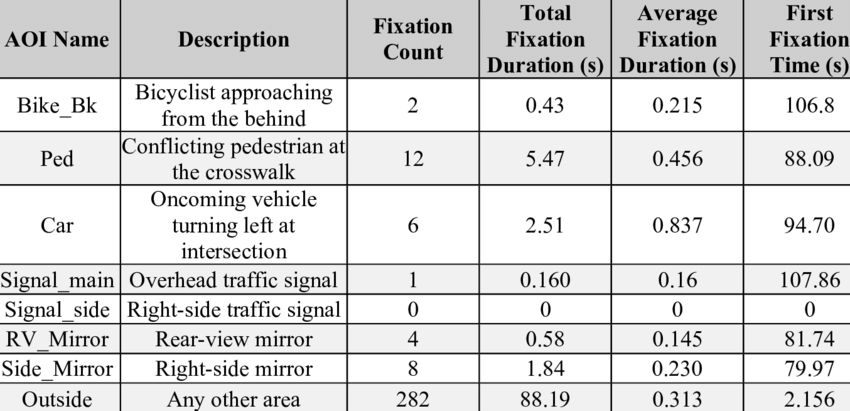

In [2]:
image_path = "./table1.png"
image_df= spark.read.format("binaryFile").load(image_path)
display_images(BinaryToImage().transform(image_df), "image")

### Extract the table and display it on the browser

In [5]:
from sparkocr.pretrained import *

pipeline = PretrainedPipeline('basic_table_extractor', 'en', 'clinical/ocr')
results = pipeline.transform(image_df).cache()
display_tables(results, table_col = "tables", table_index_col = "table_index")

basic_table_extractor download started this may take some time.
Approx size to download 23.1 MB
[OK!]
Filename: table1.png
Page: 0
Table: 0
Number of Columns: 6


col0,col1,col2,col3,col4,col5
Empty,Description,Fixation cm,Total Fixation Duration (s),Average Fixation Duration,First Fixation (s)
Bike_Bk,Bieyelis! approaching,2,0.43,0.215,106.8
Ped,(Conflicting pedestrian at| the crosswalk,RD,5.47,0.456,88.09
Car,Oncoming vehicle turning left at intersection,6,2.51,0.837,94.70
Signal_main|,Overhead traffic signal,1,0.160,0.16,107.86
Signal_side,Right-side traffic signal,0,0,0,0
RV_Mirror,Rear-view mirror,4,0.58,0.145,81.74
Side_Mirror,Right-side mirror,8,1.84,0.230,79.97
Outside,Any other area,282,88.19,0.313,2.156


### Explore the dataframe result

In [45]:
results.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- resolution: integer (nullable = false)
 |    |-- data: binary (nullable = true)
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- pagenum: integer (nullable = true)
 |-- hocr: string (nullable = true)
 |-- cells: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- index: integer (nullable = false)
 |    |    |-- page: integer (nullable = false)
 |    |    |-- x: float (nullable = false)
 |    |    |-- y: float (nullable = false)
 |    |    |-- width: float (nullable = false)
 |    |    |-- height: float (nullable = false)
 |    |    |-- score: float (nullable = false)
 |    |    |-- label: string (nullabl

### Play with the output

In [46]:
tables = results.select("tables.chunks").collect()

In [47]:
for row in tables[0].chunks:
    for cell in row:
        print(cell.chunkText, end=",")
    print("\n")

,Description,Fixation cm,Total Fixation Duration (s),Average Fixation Duration,First Fixation (s),

Bike_Bk,Bieyelis! approaching,2,0.43,0.215,106.8,

Ped,(Conflicting pedestrian at| the crosswalk,RD,5.47,0.456,88.09,

Car,Oncoming vehicle turning left at intersection,6,2.51,0.837,94.70,

Signal_main|,Overhead traffic signal,1,0.160,0.16,107.86,

Signal_side,Right-side traffic signal,0,0,0,0,

RV_Mirror,Rear-view mirror,4,0.58,0.145,81.74,

Side_Mirror,Right-side mirror,8,1.84,0.230,79.97,

Outside,Any other area,282,88.19,0.313,2.156,



### Pipeline in detail
Let's try to tackle some other problems and add more flexibility.</br>
These are the stages for previous pipeline,

In [8]:
pipeline.stages

[BinaryToImage_65cf41a4173e,
 ImageToHocr_1803c98692c2,
 IMAGE_TABLE_CELL_DETECTOR_cc1cc093c234,
 HocrToTextTable_2e13e542c1c8]

## A more complex example


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/webinars/zs_table_processing/single_page.jpg
    Resolution: 0 dpi
    Width: 1061 px
    Height: 1373 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


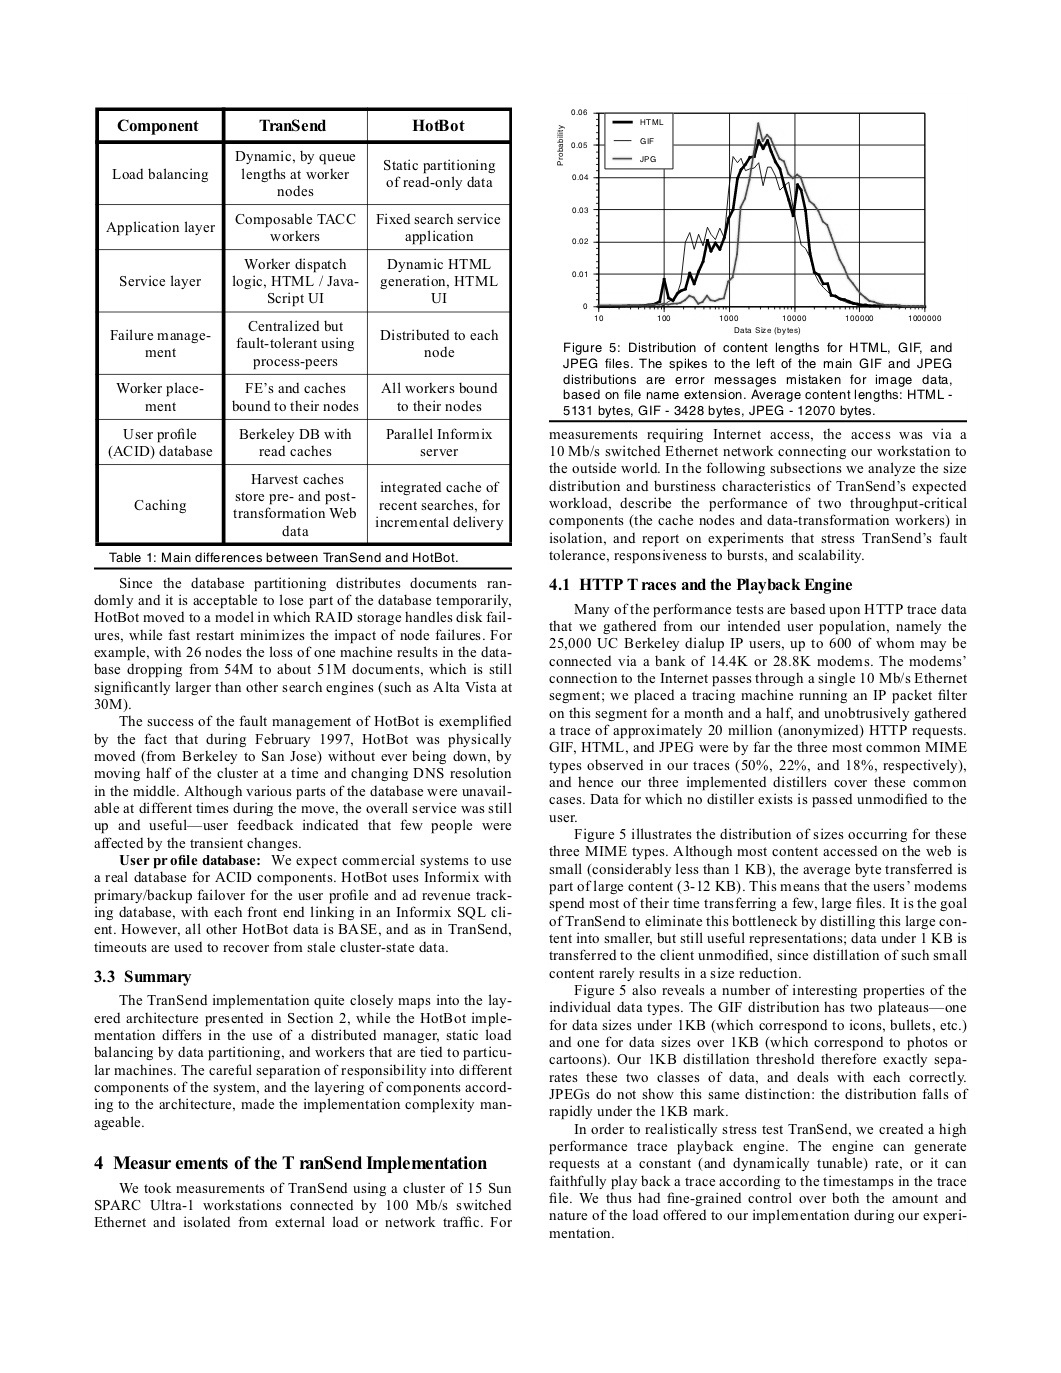

In [7]:
image_path = "./data/single_page.jpg"
image_df= spark.read.format("binaryFile").load(image_path)
display_images(BinaryToImage().transform(image_df))

### Let's define a new pipeline,
This time let's build it from scratch so we can pick the components we want.

In [3]:
binary_to_image = BinaryToImage()\
    .setOutputCol("image")

table_detector = ImageTableDetector\
    .pretrained("general_model_table_detection_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("table_regions")

splitter = ImageSplitRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("table_regions") \
    .setOutputCol("table_image") \
    .setDropCols("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

pipeline = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    splitter
])

pipeline.transform(image_df).write.\
  format("binaryFormat").\
  option("extension", "PNG").\
  option("nameField", "fileName").\
  option("type", "image").\
  option("field", "table_image").\
  save("./table_images")

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB


NameError: name 'image_df' is not defined

In [6]:
img_to_hocr = ImageToHocr() \
    .setInputCol("image") \
    .setOutputCol("hocr") \
    .setIgnoreResolution(False) \
    .setOcrParams(["preserve_interword_spaces=0"])

cell_detector = ImageDocumentRegionDetector() \
    .pretrained("region_cell_detection", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("cells") \
    .setScoreThreshold(0.8)

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("cells") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green)

hocr_to_table = HocrToTextTable() \
    .setInputCol("hocr") \
    .setOutputCol("tables")\
    .setUseCellsCol("cells")

#.setRegionCol("table_regions") \
#hocr_to_table.setOutputFormat(TableOutputFormat.CSV)

pipeline = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    cell_detector,
    draw_regions,
    hocr_to_table
])

region_cell_detection download started this may take some time.
Approximate size to download 23.1 MB


In [18]:
image_path = "./table_images"
image_df= spark.read.format("binaryFile").load(image_path)

In [19]:
result = pipeline.transform(image_df)

### Show text regions


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/webinars/zs_table_processing/table_images/ocr_-00000-622cf437-ded4-494b-9247-3f6d69f6a028-c000.PNG
    Resolution: 0 dpi
    Width: 419 px
    Height: 443 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


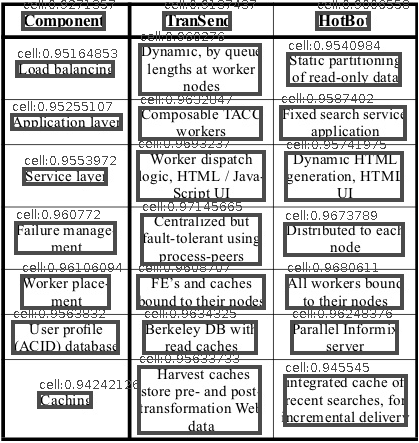

In [20]:
display_images(result, "image_with_regions")

### Display recognized tables

In [21]:
display_tables(result, table_col = "tables", table_index_col = "table_index")

Filename: ocr_-00000-622cf437-ded4-494b-9247-3f6d69f6a028-c000.PNG
Page: 0
Table: 0
Number of Columns: 3


col0,col1,col2
Empty,Empty,Empty
Load balancing,"Dynamic, by queue Iengths at worker nodes",Static partitioning of read-only data
Application layer,Composable TACC workers,Fixed search service application
Service layer,"Worker dispatch logic, HTML / Java- Script UL","Dynamic HTML, generation, HTML, UL"
Failure manage- ment,Centralized but fault-tolerant using process-peers,Distributed each to node
Worker place- ment,FE’s and caches bound their nodes to,All workers bound their nodes to
User profile (ACID) database,Berkeley DB with read caches,Parallel Informix server
Caching,Harvest caches store pre-and post- transformation Web data,"integrated cache of recent searches, for incremental delivery"


### CSV Output

In [23]:
from sparkocr.enums import *
hocr_to_table.setOutputFormat(TableOutputFormat.CSV)
result = pipeline.transform(image_df)

In [24]:
with open("my_table.csv", "w") as f:
    f.write(result.select("tables").collect()[0].tables)

In [25]:
!cat my_table.csv

,,
Load balancing,"Dynamic, by queue Iengths at worker nodes",Static partitioning of read-only data
Application layer,Composable TACC workers,Fixed search service application
Service layer,"Worker dispatch logic, HTML / Java- Script UL","Dynamic HTML, generation, HTML, UL"
Failure manage- ment,Centralized but fault-tolerant using process-peers,Distributed each to node
Worker place- ment,FE’s and caches bound their nodes to,All workers bound their nodes to
User profile (ACID) database,Berkeley DB with read caches,Parallel Informix server
Caching,Harvest caches store pre-and post- transformation Web data,"integrated cache of recent searches, for incremental delivery"
